In [2]:
import sys, os



%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
from simulation_engine.algorithms.apid import Apid
from simulation_engine.algorithms.apid_src.src.models.apid import APID

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds
from hydra import compose, initialize
from omegaconf import OmegaConf

C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\apid.py:138: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name=f'config.yaml', config_path='./apid_src/config/')


In [23]:
# args = {'dataset': {'n_samples': 10, 'Y_f': 0.0, 'T_f': 0, '_target_': 'src.data.MultiModal', 'name': 'multi_modal'}, 'model': {'name': 'apid', '_target_': 'apid_src.models.apid.APID', 'dim_u': 2, 'n_trans': 15, 'tol': 0.0001, 'aug_mode': 's', 'n_quantiles': 32, 'eps': 0.5, 'batch_size': 32, 'burn_in_epochs': 10, 'q_epochs': 10, 'curv_epochs': 3, 'noise_std': 0.001, 'lr': 0.01, 'cf_only': True, 'ema_q': 0.99, 'q_coeff': 2.0, 'curv_coeff': 0.0}, 'exp': {'seed': 10, 'device': 'cpu', 'logging': True, 'mlflow_uri': 'http://127.0.0.1:5000'}}
# Set up the config directory and config name
# Ensure the project root is in sys.path so 'src' is importable for Hydra instantiation

print('Project root added to sys.path:', project_root)
with initialize(config_path="./algorithms/apid_src/config", version_base=None):
    # Compose the config with overrides as needed
    cfg = compose(config_name="config.yaml", overrides=[
        "+dataset=multi_modal",
        "+model=apid",  # Use +model=apid to append to the defaults list
        "exp.seed=10",
        "exp.logging=True",
        "exp.device=cpu"
    ])
    # Optionally print config for debugging
    # print(OmegaConf.to_yaml(cfg))
    # Call the static method directly
    APID.run(cfg)


Project root added to sys.path: d:\TUM Workspace\Thesis Workspace\causal-bounds


INFO:simulation_engine.algorithms.apid:
dataset:
  n_samples: 10
  Y_f: 0.0
  T_f: 0
  _target_: src.data.MultiModal
  name: multi_modal
model:
  name: apid
  _target_: src.models.apid.APID
  dim_u: 2
  n_trans: 15
  tol: 0.0001
  aug_mode: s
  n_quantiles: 32
  eps: 0.5
  batch_size: 32
  burn_in_epochs: 10
  q_epochs: 10
  curv_epochs: 3
  noise_std: 0.001
  lr: 0.01
  cf_only: true
  ema_q: 0.99
  q_coeff: 2.0
  curv_coeff: 0.0
exp:
  seed: 10
  device: cpu
  logging: true
  mlflow_uri: http://127.0.0.1:5000

Seed set to 10


InstantiationException: Error locating target 'src.data.MultiModal', set env var HYDRA_FULL_ERROR=1 to see chained exception.
full_key: dataset

In [ ]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=100, replications=1, n=500,
    # allowed_functions=['identity']
)

Apid.run_from_generate_data(data.iloc[80])

TypeError: Apid.run_direct() takes 0 positional arguments but 1 was given

# ContinousIV Test

In [43]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=100, replications=1, n=500,
    # allowed_functions=['identity']
)
data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean
0,947446,1.319853,-0.305942,-5.00000,1.303573,0.797095,0.185142,0.874859,0.011445,sigmoid,sine_sym,probit,rescaled_identity,-0.174897,0.000,0.000000,0.174897,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.008878932829104322, 0.010847358409026354, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.723417,0.0,1,0,0.798,0.029348
1,553406,1.033545,-0.338948,-4.89899,0.224593,0.801822,0.958695,0.225483,0.602592,sigmoid_shifted,zero_centered_tanh,tanh_scaled,identity,-0.105735,0.000,0.000000,0.105735,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.4480437597624659, -0.035971099349260086, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.647398,0.0,1,0,0.712,0.032974
2,156798,-1.019837,0.096447,-4.79798,0.811341,0.976503,0.171118,1.579629,0.556011,zero_centered_tanh,exp_clipped,tanh_scaled,zero_centered_tanh,-0.327073,0.000,0.000000,0.327073,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.44750005499217943, -0.44898830030784576, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.9931312397960222, 0.9998568402645...",0.999998,0.0,1,0,0.118,0.503358
3,78011,1.696127,-0.262104,-4.69697,0.603828,0.607494,0.704720,0.972552,0.326126,sin,sin,softplus,identity,-0.337150,0.000,0.000000,0.337150,"[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[-0.214482405713485, 0.06138525442490853, -0.1...","[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0.7271211492098952, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.0,1,0,0.500,0.146517
4,99111,-0.999904,-0.120246,-4.59596,-1.507825,0.002898,1.123921,0.380849,1.698189,sin,sigmoid_shifted,sigmoid,rescaled_identity,-0.276465,0.000,0.017539,0.294005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.015854770778718, -1.3499236585095864, -2.4...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.426737,0.0,1,0,0.510,0.007625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,159540,0.913609,0.580143,4.59596,-2.432955,0.423287,0.621616,0.436216,0.447447,identity,exp_clipped,sigmoid,tanh,0.697389,1.000,0.998122,0.300733,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0529246624884283, -0.7421605622628071, -0.0...","[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...","[0.941823917206696, 0.0, 0.0, 0.98026511755714...",0.999730,0.0,1,0,0.544,0.426654
96,195499,-1.678640,0.760014,4.69697,1.203294,0.054771,1.174074,0.824275,0.319159,exp_clipped,sin,tanh_scaled,zero_centered_tanh,0.718921,1.000,0.999230,0.280310,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0.6974268024452993, 0.3576348597828265, 0.163...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, ...","[0.9999954455332897, 0.9995101541559803, 0.999...",0.999999,0.0,1,0,0.678,0.752981
97,423636,-0.693674,-1.676605,4.79798,1.336855,0.015128,1.103836,0.448779,0.297513,sine_sym,sin,tanh_scaled,zero_centered_tanh,0.770185,1.000,0.999745,0.229561,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02878274786286544, 0.09522384176466536, -0....","[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.999771485759161, 0.9995793074181535, 0...",0.999985,0.0,1,0,0.494,0.639118
98,328883,1.808933,0.593199,4.89899,0.840149,0.309459,0.369677,2.270330,0.654113,cos,exp_neg_sq,tanh_scaled,sine_sym,0.033563,0.404,0.365113,0.331550,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0.14556257623617974, -0.1402055731077859, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0.0, 0.9713062180074945, 0.9869989859246147, ...",0.999996,0.0,1,0,0.830,0.329894


In [44]:
contIV = ContinuousIV('IV Dag', data, 1)
contIV.run()
# contIV.binaryIV.data
contIV.data

Running ATE_zhangbareinboim...
Error in ZhangBareinboim: ((0, 0), 1)
ATE_zhangbareinboim completed in 24.80 seconds.
Running ATE_causaloptim-binned...
Entering binned Binary IV Scenario for algorithm: ATE_causaloptim
Running ATE_causaloptim...
ATE_causaloptim completed in 46.14 seconds.
Total runtime: 46.14 seconds.
Exiting binned Binary IV Scenario.
ATE_causaloptim-binned completed in 46.14 seconds.
Running ATE_autobound...
Entering binned Binary IV Scenario for algorithm: ATE_autobound
Running ATE_autobound...
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
Error in AutoBound: Model constraint (c0) contains nonlinear terms tha

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,ATE_zhangbareinboim_bound_lower,ATE_zhangbareinboim_bound_upper,ATE_zhangbareinboim_bound_valid,ATE_zhangbareinboim_bound_width,ATE_zhangbareinboim_bound_failed,ATE_causaloptim-binned_bound_lower,ATE_causaloptim-binned_bound_upper,ATE_causaloptim-binned_bound_valid,ATE_causaloptim-binned_bound_width,ATE_causaloptim-binned_bound_failed,ATE_autobound-binned_bound_lower,ATE_autobound-binned_bound_upper,ATE_autobound-binned_bound_valid,ATE_autobound-binned_bound_width,ATE_autobound-binned_bound_failed
0,947446,1.319853,-0.305942,-5.00000,1.303573,0.797095,0.185142,0.874859,0.011445,sigmoid,sine_sym,probit,rescaled_identity,-0.174897,0.000,0.000000,0.174897,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.008878932829104322, 0.010847358409026354, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.723417,0.0,1,0,0.798,0.029348,-0.551724,0.060255,True,0.611979,False,-1.000000,1.000000,True,2.000000,True,-0.551724,0.060255,True,0.611979,False
1,553406,1.033545,-0.338948,-4.89899,0.224593,0.801822,0.958695,0.225483,0.602592,sigmoid_shifted,zero_centered_tanh,tanh_scaled,identity,-0.105735,0.000,0.000000,0.105735,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.4480437597624659, -0.035971099349260086, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.647398,0.0,1,0,0.712,0.032974,-0.407407,0.200477,True,0.607885,False,-1.000000,1.000000,True,2.000000,True,-0.407407,0.200477,True,0.607885,False
2,156798,-1.019837,0.096447,-4.79798,0.811341,0.976503,0.171118,1.579629,0.556011,zero_centered_tanh,exp_clipped,tanh_scaled,zero_centered_tanh,-0.327073,0.000,0.000000,0.327073,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.44750005499217943, -0.44898830030784576, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",0.999998,0.0,1,0,0.118,0.503358,-0.634319,0.183677,True,0.817996,False,-0.634319,0.193530,True,0.827849,False,-0.634319,0.183677,True,0.817996,False
3,78011,1.696127,-0.262104,-4.69697,0.603828,0.607494,0.704720,0.972552,0.326126,sin,sin,softplus,identity,-0.337150,0.000,0.000000,0.337150,"[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[-0.214482405713485, 0.06138525442490853, -0.1...","[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1.000000,0.0,1,0,0.500,0.146517,-0.567308,0.226884,True,0.794191,False,-0.548999,0.109260,True,0.658259,False,-0.567308,0.226884,True,0.794191,False
4,99111,-0.999904,-0.120246,-4.59596,-1.507825,0.002898,1.123921,0.380849,1.698189,sin,sigmoid_shifted,sigmoid,rescaled_identity,-0.276465,0.000,0.017539,0.294005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.015854770778718, -1.3499236585095864, -2.4...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.426737,0.0,1,0,0.510,0.007625,-0.510000,0.490000,True,1.000000,False,0.490000,0.490000,False,0.000000,False,-1.000000,1.000000,True,2.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,159540,0.913609,0.580143,4.59596,-2.432955,0.423287,0.621616,0.436216,0.447447,identity,exp_clipped,sigmoid,tanh,0.697389,1.000,0.998122,0.300733,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0529246624884283, -0.7421605622628071, -0.0...","[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.999730,0.0,1,0,0.544,0.426654,0.076378,0.877451,True,0.801073,False,0.111089,0.877451,True,0.766362,False,0.076378,0.877451,True,0.801073,False
96,195499,-1.678640,0.760014,4.69697,1.203294,0.054771,1.1740

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
ATE_causaloptim-binned          5.00            11.58          0.7284      0.9319
  ATE_autobound-binned         10.00             3.33          0.7804      0.9390
   ATE_zhangbareinboim          1.00             3.03          0.7817      0.8304


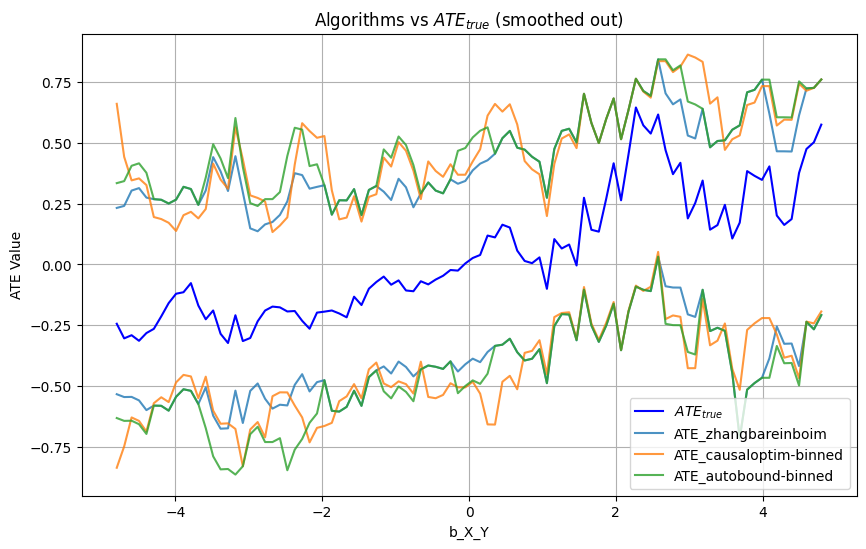

In [51]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs, 5)

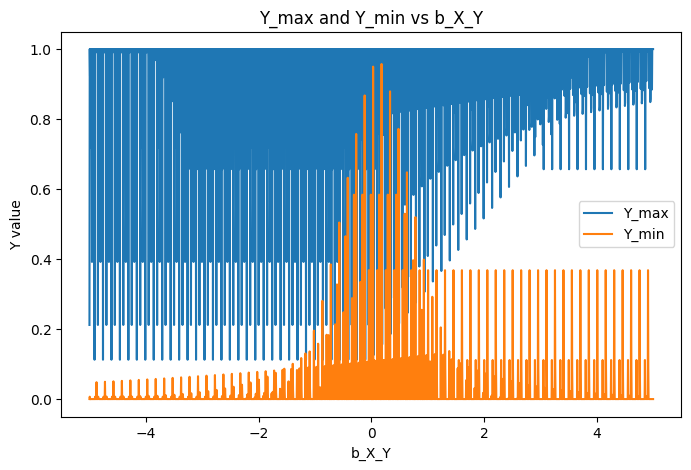

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

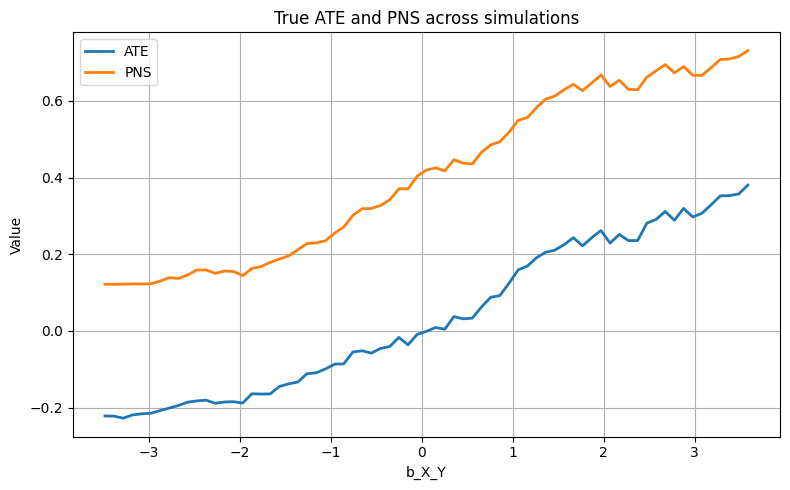

In [46]:
PlottingUtil.plot_ate_pns(data, window=30)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run_all_bounding_algorithms(algorithms)

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.19 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.25 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 6.28 seconds.
Running ATE_autobound...
ATE_autobound completed in 4.71 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.59 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.59 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.63 seconds.
Running ATE_nonpara...
ATE_nonpara completed in 0.01 seconds.
Total runtime: 13.26 seconds.


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
           PNS_nonpara          0.00            16.00          0.1784
       PNS_causaloptim          4.00             9.38          0.4198
         PNS_autobound          1.00             0.00          0.4283
PNS_entropybounds-0.10          0.00             0.00          0.5021
PNS_entropybounds-0.20          0.00             0.00          0.5752
PNS_entropybounds-0.80          0.00             0.00          0.7197
    PNS_zaffalonbounds           N/A              N/A             N/A


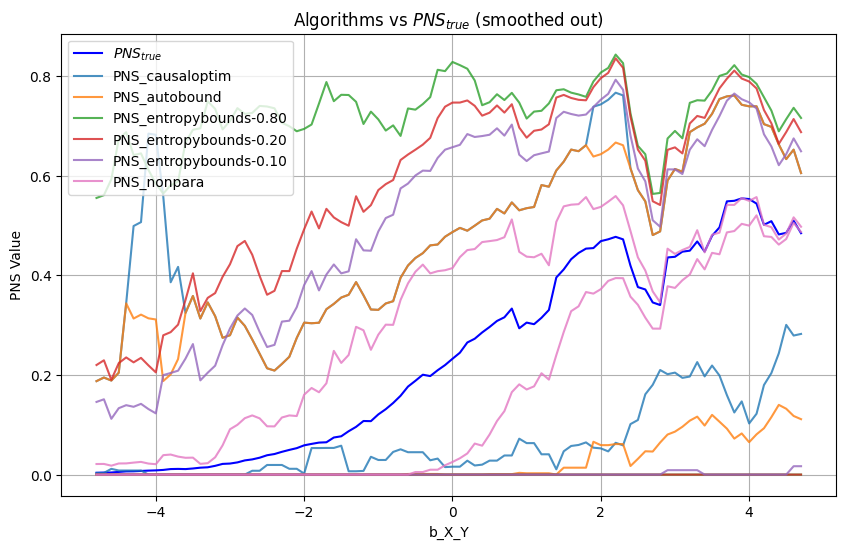

In [28]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('PNS')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', ate_algs, 5, False)